In [15]:
import numpy as np
import pandas as pd
import datetime as dt
from tqdm import tqdm

from sklearn.decomposition import NMF
from sklearn.preprocessing import normalize

import matplotlib.pyplot as plt
import matplotlib.colors as colors_
from matplotlib.pyplot import text
from matplotlib.gridspec import GridSpec
from mpl_toolkits import mplot3d
import json
import gmaps

from os import path
import pickle
import geopandas as gpd
import requests
import pycountry
from shapely.ops import nearest_points
import holidays as holiday_module
from importlib import reload
import utils
import random
import shapely
import joypy
import matplotlib.cm as cm
from matplotlib.dates import MonthLocator
from scipy.ndimage import uniform_filter1d
from scipy.stats import pearsonr
import holidays as holiday_module
import networkx as nx
from os import listdir
import seaborn as sns

reload(utils)


%matplotlib inline


# Loading in data

In [16]:
# PATH_IN = # censored
# PATH_IN_ZIPS = # censored
# start_date = dt.datetime(2020, 3, 1)

# # Phone data
# data = utils.load_prepare(PATH_IN,PATH_IN_ZIPS,start_date)
# data = data[data.date<='2020-12-06']


# # Removing some outlier dates
# dat_tmp = data.groupby('date').sum()['n_crisis']
# outlier_dates = dat_tmp.index[[dat_tmp.argmin(),*dat_tmp.argsort()[-2:]]]
# data = data[~data.date.isin(outlier_dates)]
# print(f"Removed the following dates: {outlier_dates}")



# dates= sorted(np.unique(data.date.to_list()))
with open('metadata.pkl', 'rb') as f:
    dates, locations = pickle.load(f)
start_date = dates[0]

# locations = sorted(data.target_kommune.unique())
loc_replace = {loc: i for i,loc in enumerate(locations)}

pd_demo, pd_pep = utils.load_demo_and_pop()
population = pd_pep.set_index('kommune').loc[locations].population.tolist()
population = np.array([population[i//len(locations)] for i in range(len(locations)*len(locations))])

topics = ["Holiday", "Weekend", "Workday"]
country_conversion = {'Spain':'ESP','Denmark':'DNK','France':'FRA','Italy':'ITA'}

lockdown_df = utils.get_lockdown_dates(['DNK','ESP','FRA','ITA'])
lockdown_dates = np.array(dates)[np.array([date in lockdown_df.get_group('DNK').date_value.to_list() for date in dates])]

In [17]:
# Cartograms made with the use of https://github.com/Flow-Based-Cartograms/go_cart
# Look at https://github.com/Flow-Based-Cartograms/go_cart/issues/26 if you are having trouble saving the GeoJSON file

cartogram = gpd.read_file("denmark.json")
poly_list = cartogram.geometry.to_list()
cartogram = gpd.GeoDataFrame({'name':cartogram.NAME_2, 'geometry':poly_list})
cartogram['name'] = cartogram.name.str.replace('-', ' ')
cartogram = cartogram[cartogram.name.isin(locations)]
cartogram = cartogram.set_index('name')

geo_df = cartogram.copy()
##MOVE BORNHOLM
bornholm = geo_df.loc[['Bornholm']].copy()
bornholm['geometry'] = bornholm['geometry'].apply(lambda x: shapely.affinity.translate(x, xoff=-80, yoff=-20))
geo_df.loc["Bornholm","geometry"] = bornholm.loc["Bornholm","geometry"]
geo_df = geo_df.copy()
geo_df = geo_df.set_geometry('geometry')
geo_df['centroid'] = geo_df.centroid


centroids = geo_df[['centroid']].to_dict()['centroid']

# Compute NMF

In [18]:
c_all_pop = utils.brain(None, population = population, in_out = 'in', path_full_file = True)
c_all_pop.compute_NMF(3, t_method=np.sqrt)

Computing NMF with 3 components


In [19]:
topic_threshold_none = np.ones(c_all_pop.nmf_t.shape)# Choose which data to use

net, mask = c_all_pop.nmf_t, topic_threshold_none

# Keep only the biggest value in each row
dat_only_big = net * mask 

# Creating two list that creates all the pairs of locations for the links
source_locations = [ locations[i//len(locations)] for i in range(len(locations)**2)]
target_locations = [ locations[i%len(locations)] for i in range(len(locations)**2)]
# Corresponding lists containing the centroids instead of the names
A = [ centroids[loc] for loc in source_locations]
B = [ centroids[loc] for loc in target_locations]



# Create a dictionary containing the different dataset that we want to visualize. 
data_dict = {}
for i in range(net.shape[1]):
    data_dict[f"topic_{i}"] = utils.create_flow_dataset(net[:,i],source_locations, target_locations, A, B)
    data_dict[f"topic_{i}_big"] = utils.create_flow_dataset(dat_only_big[:,i],source_locations, target_locations, A, B)


# Visualizations

 ## Figure 1

Text(2020-01-19 00:00:00, -0.185, 'C)')

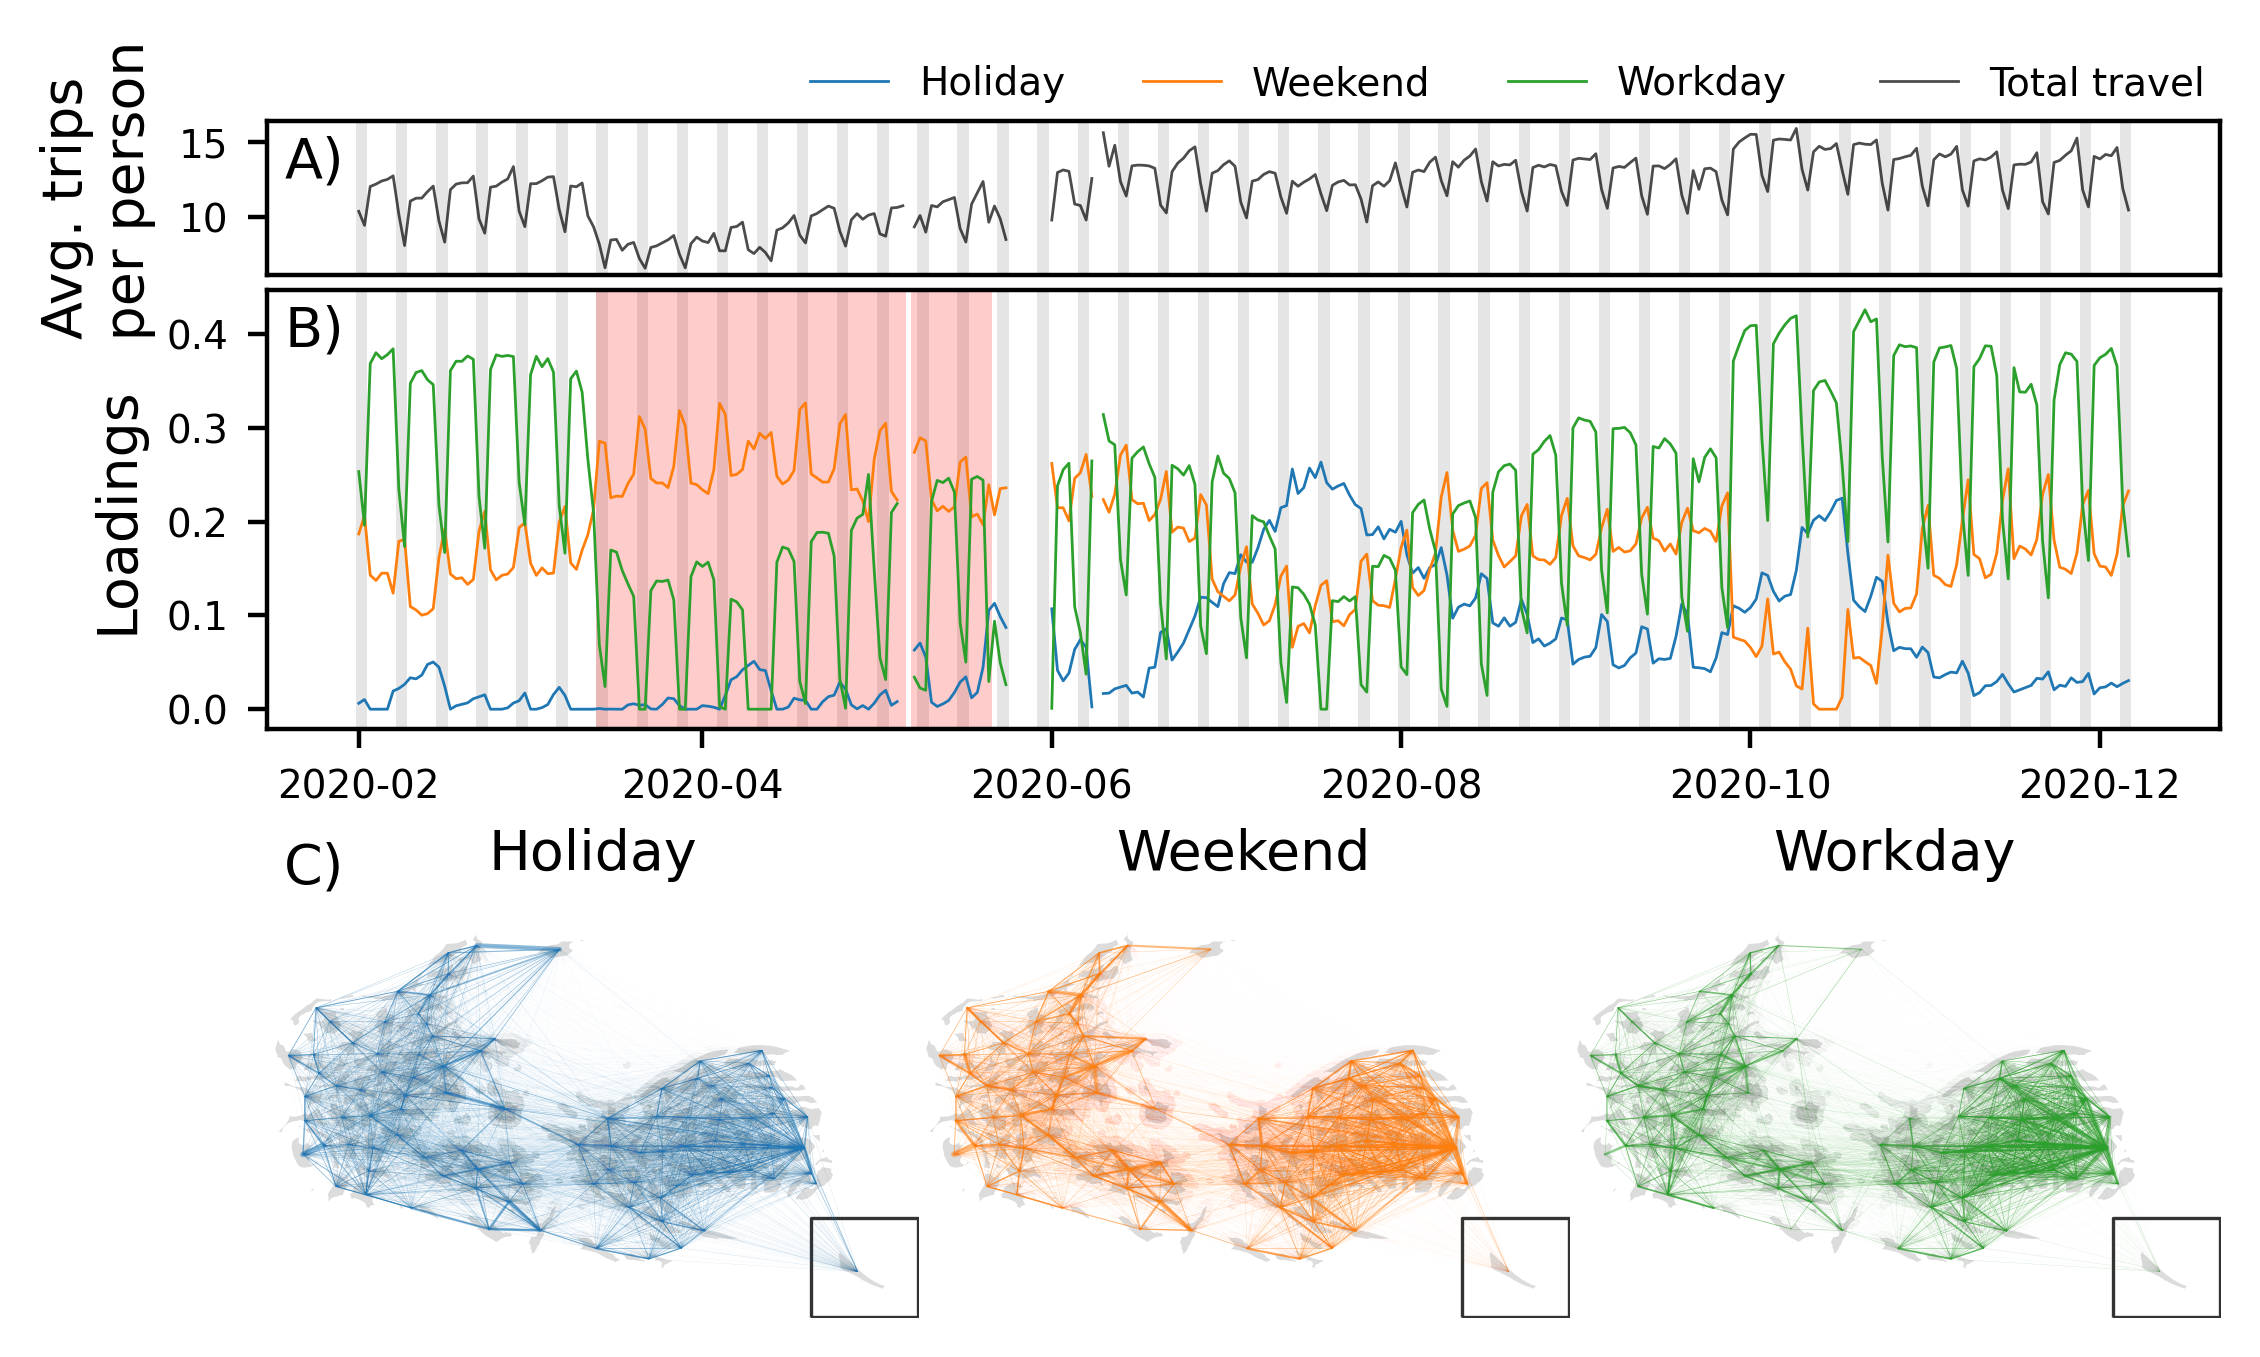

In [20]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

fig = plt.figure(figsize=(6.3,4), dpi=400)
plt.subplots_adjust(hspace=0.05, wspace=0)
gs = GridSpec(4,3, figure=fig, height_ratios=[0.7,2,0.6,2])

axes_dict = {}

# data_plot = pd.concat([pd.DataFrame(c_all_pop.nmf_w.T, index = c_all_pop.dates),data.groupby('date').sum()['n_crisis']], axis=1).resample('D').mean()
with open('data_plot.pkl', 'rb') as f:
    data_plot = pickle.load(f)

power = 1.5 
for j in range(3): 
    temp_data = data_dict[f"topic_{j}_big"].copy()
    temp_data.total_normalized = np.power(temp_data.total_normalized, power)
    
    max_data = temp_data.total_normalized.max()
    factor, coeff = utils.compute_factor(0.000, 1.00, 0, max_data)
    axes_dict[j] = fig.add_subplot(gs[3,j])
    axes_dict[j].set_title(f'{topics[j]}', fontsize=10)
    utils.plot_network(axes_dict[j],temp_data , geo_df, factor, coeff, bornholm=bornholm, color=colors[j])
    
weekend_idx = [i for i, date in enumerate(data_plot.index) if date.isoweekday()>=6]

axes_dict[4] = fig.add_subplot(gs[0,:])
axes_dict[4].plot(data_plot.index,data_plot.n_crisis*100/18/5792202,linewidth=0.5, color='black', alpha = 0.7)
for idx in weekend_idx:
    plt.axvspan(data_plot.index[idx]-dt.timedelta(hours=12), data_plot.index[idx]+dt.timedelta(hours=12), facecolor='gray', alpha=0.2, edgecolor='none')
axes_dict[4].set_xticks([])
axes_dict[4].yaxis.offsetText.set_fontsize(7)


            
# Lineplot over time
axes_dict[5] = fig.add_subplot(gs[1,:])
if c_all_pop.nmf_w is None:
    c_all_pop.compute_NMF()

for idx in weekend_idx:
    plt.axvspan(data_plot.index[idx]-dt.timedelta(hours=12), data_plot.index[idx]+dt.timedelta(hours=12), facecolor='gray', alpha=0.2, edgecolor='none')

for i in range(c_all_pop.nmf_w.shape[0]):
    plt.plot(data_plot.index,data_plot[i],linewidth=0.5)


events = ['Lockdown', 'Restaurants open']
height_scale = [0.93,0.81]
#lockdown_dates = utils.get_lockdown_dates(['ITA','DNK']).get_group('DNK').date_value.to_list()
for period in lockdown_dates:
    if period<=data_plot.index[-1]:
        axes_dict[5].axvspan(period-dt.timedelta(hours=12),period+dt.timedelta(hours=12),facecolor='red', alpha=0.2, edgecolor='none')
# text(dt.date(2020,3,11)+dt.timedelta(days=1), c_all_pop.nmf_w.max()*height_scale[0], f"{events[0]} ",horizontalalignment='left',fontsize=7)
# for i, date in enumerate([dt.date(2020,3,11),dt.date(2020,5,11)]):
#     plt.axvline(date, linestyle='--',color='black', alpha=0.8, linewidth=0.5)
#     text(date+dt.timedelta(days=1), c_all_pop.nmf_w.max()*height_scale[i], f"{events[i]} ",horizontalalignment='left',fontsize=7)
    
    
#axes_dict[4].set_position([box.x0, box.y0, box.width * 0.8, box.height])
axes_dict[4].legend(['Total travel'],prop={"size":7}, loc='lower right', bbox_to_anchor=(0,1.02,1,0.2), borderaxespad=0, ncol=1, frameon=False)
axes_dict[5].legend([f'{topics[i]}' for i in range(c_all_pop.nmf_w.shape[0])],prop={"size":7}, loc='lower left', bbox_to_anchor=(0.27,1.39,1,0.2), borderaxespad=0, ncol=3, frameon=False)
axes_dict[5].xaxis.set_major_locator(MonthLocator(interval=2))
axes_dict[4].tick_params(axis='y', labelsize=7)
axes_dict[5].tick_params(axis='x', labelsize=7)
axes_dict[5].tick_params(axis='y', labelsize=7)
axes_dict[5].set_ylabel('Loadings')
axes_dict[4].set_ylabel('Avg. trips \n per person')

x_text = c_all_pop.dates[0]-dt.timedelta(days=13)
y_offset = 0.023
# x_text = c_all_pop.dates[0]-dt.timedelta(days=50)
axes_dict[5].text(x_text,0.59-y_offset,'A)',fontsize=10)
axes_dict[5].text(x_text,0.41-y_offset,'B)',fontsize=10)
axes_dict[5].text(x_text,-0.185,'C)',fontsize=10)



In [22]:
with open("Denmark.pkl", 'rb') as f:
    geo_df = pickle.load(f)
geo_df = geo_df[geo_df.adm2.isin(locations)].set_index('adm2')

distances = np.array([utils.haversine(geo_df.loc[loc_ori]['centroid'].x,geo_df.loc[loc_ori]['centroid'].y,geo_df.loc[loc_tar]['centroid'].x,geo_df.loc[loc_tar]['centroid'].y) for loc_ori in locations for loc_tar in locations if loc_ori!=loc_tar])
dat_no_loc = np.array([c_all_pop.nmf_t[i,:] for i in range(98*98) if i%98 != i//98 ])
print("Weighted distance in km and variance")
for i in range(3):
    print(f'{topics[i]}')
    print(utils.weighted_avg_and_std(distances, dat_no_loc[:,i]))

Weighted distance in km and variance
Holiday
(80.09756572172226, 66.99655841771421)
Weekend
(59.007401080661204, 55.24144828282455)
Workday
(56.0948218903328, 54.1393353987262)


## Figure 2

/Users/petem/Dropbox/Peter_Dropbox/Uni/PhD/nmf_github/utils.py:640: FutureWarning: The default value of regex will change from True to False in a future version.
  #Removing special cases
/Users/petem/Dropbox/Peter_Dropbox/Uni/PhD/nmf_github/utils.py:640: FutureWarning: The default value of regex will change from True to False in a future version.
  #Removing special cases
/Users/petem/Dropbox/Peter_Dropbox/Uni/PhD/nmf_github/utils.py:640: FutureWarning: The default value of regex will change from True to False in a future version.
  #Removing special cases


[[[0.014508861940019598, 0.044097447748435395], [0.03965986646975739, 0.031063902473254332], [0.03127959152662387, 0.042585432409604475]], [[0.007158533656894016, 0.04106698129206978], [0.037638116327354754, 0.030029915655687307], [0.030705797599891053, 0.040043420748596514]], [[0.0028583118504756882, 0.042450935196091284], [0.045824328494947095, 0.03900367841158095], [0.038350688556851364, 0.04748224793392174]]]


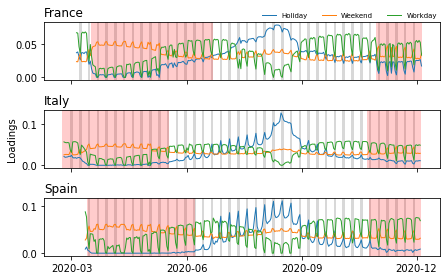

In [23]:
countries = ["France", "Italy", "Spain"]
# countries = ["Germany", "Italy", "Spain"]
links = [True]
N = [3]
adms = [2]
file_types = ["admin"] #,"tile"]
corona_daily_cases = pd.read_csv("https://opendata.ecdc.europa.eu/covid19/casedistribution/csv/data.csv")
corona_daily_cases.dateRep = pd.to_datetime(corona_daily_cases.dateRep, dayfirst = True)
res = []

fig, ax = plt.subplots(3,1, figsize=(6.4,4), sharex = 'col')
i = 0
for country in countries:
    country_short = country_conversion[country]
    for link in links:
        for n in N:
            for adm in adms:
                for file_type in file_types:
                    nmf_topics, nmf_weights, dates, _ = utils.create_fb_figures(country, n, adm, link, file_type, return_nmf = True, population = True, ax = ax[i], lockdown = lockdown_df, path_full_file=True)
                    nmf_weekends = [1 if i.isoweekday()>=6 else 0 for i in dates]
                    corona_daily_country = corona_daily_cases[corona_daily_cases.countriesAndTerritories == country]
                    mask_fb = (corona_daily_country.dateRep >= dates.min()) & (corona_daily_country.dateRep <= dates.max())
                    corona_daily_country = corona_daily_country.loc[mask_fb] 
                    weekend_corr = [np.corrcoef(nmf_weekends, nmf_weights[i,:])[0,1] for i in range(3)]
                    corona_corr = 0 #[np.corrcoef(corona_daily_country.deaths.tolist(), nmf_weights[i,:])[0,1] for i in range(nmf_weights.shape[0])]
                    lockdown_dates_boo = np.array([date in lockdown_df.get_group(country_short).date_value.to_list() for date in dates])
                    res.append([[nmf_weights[top,lockdown_dates_boo].mean(),nmf_weights[top,~lockdown_dates_boo].mean()] for top in range(3)])
                    #print(res)
                    i+=1
print(res)
ax[0].legend(['Holiday','Weekend','Workday'],prop={"size":7}, loc='lower right', bbox_to_anchor=(0,1.02,1,0.2), borderaxespad=0, ncol=3, frameon=False)
plt.tight_layout()


In [24]:
country_short = 'FRA'
for country in ['France','Spain','Italy']:
    print(f'Country: {country}')
    country_short = country_conversion[country]
    nmf_t, nmf_w, dates, X_fb = utils.create_fb_figures(country, 3, 2, True, 'admin', return_nmf_only = True, population = True, path_full_file=True)
    overall_trend = X_fb.sum(axis=0)
    c_deaths, c_weekends, c_workdays, c_vacation = utils.get_corona_numbers(country,dates)

    t_method = np.sqrt
    weekend_corr, weekend_p = np.array([pearsonr(c_weekends, nmf_w[i,:]-uniform_filter1d(nmf_w[i,:],7)) for i in range(nmf_w.shape[0])]+[pearsonr(c_weekends,overall_trend)]).T
    workday_corr, workday_p = np.array([pearsonr(c_workdays, nmf_w[i,:]-uniform_filter1d(nmf_w[i,:],7)) for i in range(nmf_w.shape[0])]+[pearsonr(c_workdays,overall_trend)]).T
    vacation_corr, vacation_p= np.array([pearsonr(t_method(c_vacation), nmf_w[i,:]) for i in range(nmf_w.shape[0])]+[pearsonr(c_vacation,overall_trend)]).T
    corona_corr, corona_p = np.array([pearsonr(t_method(c_deaths), nmf_w[i,:]) for i in range(nmf_w.shape[0])]+[pearsonr(c_deaths,overall_trend)]).T
    print('Correlations in the order of weekend, workday and corona:')
    print(pd.DataFrame(data = np.array([weekend_corr, workday_corr, corona_corr, vacation_corr]).T, columns = ['Weekends', 'Weekdays','Corona','Vacation']))
    print('P-values for same correlations')
    print(pd.DataFrame(data = np.array([weekend_p, workday_p, corona_p, vacation_p]).T, columns = ['Weekends', 'Weekdays','Corona','Vacation']))
    print()

Country: France


/Users/petem/Dropbox/Peter_Dropbox/Uni/PhD/nmf_github/utils.py:640: FutureWarning: The default value of regex will change from True to False in a future version.
  #Removing special cases


Fetching Corona numbers
Correlations in the order of weekend, workday and corona:
   Weekends  Weekdays    Corona  Vacation
0 -0.721365  0.721365 -0.615522  0.696743
1  0.859040 -0.859040  0.384344  0.039629
2 -0.874590  0.874590 -0.187130 -0.335209
3 -0.242809  0.242809  0.362338 -0.497701
P-values for same correlations
       Weekends      Weekdays        Corona      Vacation
0  1.281013e-45  1.281013e-45  3.607140e-30  2.010953e-41
1  1.166475e-81  1.166475e-81  3.793576e-11  5.120537e-01
2  3.981247e-88  3.981247e-88  1.794094e-03  1.131866e-08
3  4.567825e-05  4.567825e-05  5.490827e-10  1.112101e-18

Country: Spain


/Users/petem/Dropbox/Peter_Dropbox/Uni/PhD/nmf_github/utils.py:640: FutureWarning: The default value of regex will change from True to False in a future version.
  #Removing special cases


Fetching Corona numbers
Correlations in the order of weekend, workday and corona:
   Weekends  Weekdays    Corona  Vacation
0  0.604533 -0.604533 -0.413511  0.790885
1  0.912924 -0.912924  0.173940 -0.064040
2 -0.931809  0.931809 -0.056661 -0.136165
3 -0.159624  0.159624  0.326201 -0.384568
P-values for same correlations
        Weekends       Weekdays        Corona      Vacation
0   4.284888e-28   4.284888e-28  1.711777e-12  1.146007e-58
1  1.587639e-105  1.587639e-105  4.290077e-03  2.962285e-01
2  4.350534e-119  4.350534e-119  3.554945e-01  2.580848e-02
3   8.851139e-03   8.851139e-03  4.618582e-08  7.095663e-11

Country: Italy


/Users/petem/Dropbox/Peter_Dropbox/Uni/PhD/nmf_github/utils.py:640: FutureWarning: The default value of regex will change from True to False in a future version.
  #Removing special cases


Fetching Corona numbers
Correlations in the order of weekend, workday and corona:
   Weekends  Weekdays    Corona  Vacation
0  0.505947 -0.505947 -0.650788  0.719384
1  0.861598 -0.861598  0.398042 -0.205588
2 -0.911895  0.911895 -0.149944 -0.082928
3 -0.328844  0.328844  0.305395 -0.585540
P-values for same correlations
        Weekends       Weekdays        Corona      Vacation
0   6.254938e-20   6.254938e-20  1.024811e-35  1.072723e-46
1   2.512765e-85   2.512765e-85  2.935787e-12  4.778942e-04
2  1.821117e-111  1.821117e-111  1.125848e-02  1.626416e-01
3   1.300129e-08   1.300129e-08  1.446939e-07  1.270954e-27



In [25]:
print("Percentage increase/decrease in loadings during lockdown compared to outside lockdown")
for i, val in enumerate(res):
    print(countries[i])
    for i, t_type in enumerate(['Holiday', 'Weekend','Workday']):
        print(f"{t_type}: {(val[i][0]-val[i][1])/val[i][1]*100:.0f}%")

Percentage increase/decrease in loadings during lockdown compared to outside lockdown
France
Holiday: -67%
Weekend: 28%
Workday: -27%
Italy
Holiday: -83%
Weekend: 25%
Workday: -23%
Spain
Holiday: -93%
Weekend: 17%
Workday: -19%


## Figure 3

In [26]:
# Threshold corresponding to the mean amount of travels taken per day per citizen.
# mean(flow_day/population_source)
# threshold = 0.0005
# mask_threshold = (c_all_pop.X.mean(axis=1)>=threshold)

# Taking all links where the mean is not 0.
quantile = 0.5 # Fraction of 0 flow for a link to be removed.
mask_threshold = (np.quantile(c_all_pop.X, quantile, axis=1) != 0)
#mask_threshold = (c_all_pop.X <=0).sum(axis=1)
print(f"Amount of removed links: {(~mask_threshold).sum()}")
print(f"Shape of the new matrix: {c_all_pop.X_t[mask_threshold].shape}")
print(f"Amount of zero links in new matrix: {(c_all_pop.X_t[mask_threshold]==0).sum()} out of {c_all_pop.X_t.size}")
print(f"Totalt amount of zeros in reconstructed flow: {((c_all_pop.nmf_t@c_all_pop.nmf_w)==0).sum()} out of {(c_all_pop.nmf_t@c_all_pop.nmf_w).size}")
print(f"The percentage of zeros is: {(c_all_pop.X_t[mask_threshold]==0).sum()/c_all_pop.X_t.size*100:.2f}%")

Amount of removed links: 2592
Shape of the new matrix: (7012, 300)
Amount of zero links in new matrix: 216512 out of 2881200
Totalt amount of zeros in reconstructed flow: 2454 out of 2881200
The percentage of zeros is: 7.51%


100%|██████████| 14/14 [00:04<00:00,  3.10it/s]


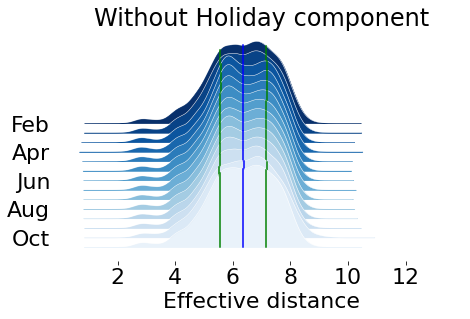

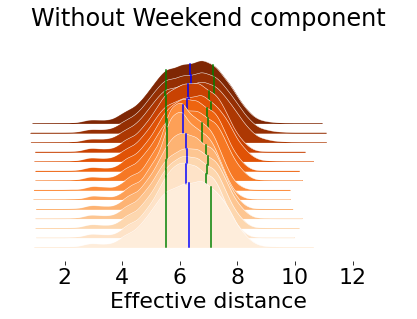

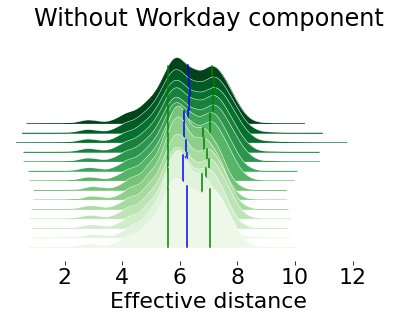

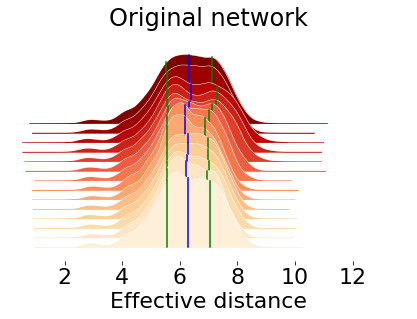

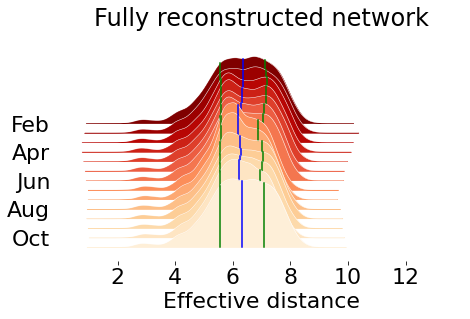

In [27]:
# Effective distance for all or subset
effective_type = ['effective_distance', 'all_effective_distance'][1]

# Make sure denmark geography data is loaded and created.
c_all_pop.create_geo_dat()
centroid_origin = c_all_pop.geo_df.centroid.to_dict()

# Creating two list that creates all the pairs of locations for the links
source_locations = [ locations[i//len(locations)] for i in range(len(locations)**2)]
target_locations = [ locations[i%len(locations)] for i in range(len(locations)**2)]
# Corresponding lists containing the centroid_origin instead of the names
A = [ centroid_origin[loc] for loc in source_locations]
B = [ centroid_origin[loc] for loc in target_locations]


cms = [cm.Blues_r, cm.Oranges_r, cm.Greens_r, cm.OrRd_r, cm.OrRd_r]
dat_tmp_t = c_all_pop.nmf_t * mask
variances = []
#dat = np.delete(c_all_pop.nmf_t,dat_type,axis=1) @ np.delete(c_all_pop.nmf_w,dat_type, axis=0)
for dat_type in range(5):
    df = pd.DataFrame()
    variances.append([])
    if dat_type == 4:
        dat = (dat_tmp_t @ c_all_pop.nmf_w)[mask_threshold]
        title = "Fully reconstructed network"
    elif dat_type == 3:
        dat = c_all_pop.X_t[mask_threshold]
        title = "Original network"
    else:
        dat = (np.delete(dat_tmp_t, dat_type,axis=1) @ np.delete(c_all_pop.nmf_w,dat_type, axis=0))[mask_threshold]
        title = f"Without {topics[dat_type]} component"
        #dat = c_all_pop.X_t - dat_tmp_t[:,dat_type][:,np.newaxis] @ c_all_pop.nmf_w[dat_type,:][np.newaxis,:]
        #dat[dat<0] = 0
        #title = f"Original network minus reconstructed network from topic {dat_type} ({topics[dat_type]})"
    quantiles = [] 
    loop_range = range(0, dat.shape[1]-20,20)
#     lockdown_boo = np.array([dates[i+10] in lockdown_dates for i in loop_range])
    lockdown_boo = np.array([sum([dates[i+j] in lockdown_dates for j in range(20)])>=10 for i in loop_range])
    #y_labels = [True if i%2==0 else False for i, x in enumerate(loop_range) ]
    if dat_type in [0,4]:
        y_labels = [c_all_pop.dates[x].month_name()[:3] for i, x in enumerate(loop_range) ]
#         y_labels = [c_all_pop.dates[x].strftime('%Y-%m-%d') for i, x in enumerate(loop_range) ]
    else:
        y_labels = ['' for i, x in enumerate(loop_range) ]
        
#     import pdb; pdb.set_trace()
    for day in tqdm(loop_range):
        dat_graph_original_day = utils.create_flow_dataset(dat[:,day:day+20].sum(axis=1), source_locations, target_locations, A, B)
        P_total = dat_graph_original_day.groupby('origin_area_code', as_index = False)['total_normalized'].sum().rename(columns={'total_normalized':'P_total'})
        dat_graph_original_day = pd.merge(dat_graph_original_day.reset_index(), P_total, on='origin_area_code', how='left').set_index('index')
        #dat_graph_original_day = dat_graph_original_day[dat_graph_original_day.P_total != 0]
        dat_graph_original_day['P'] = dat_graph_original_day.total_normalized/dat_graph_original_day.P_total

        
        if dat_graph_original_day.total_normalized.sum() == 0:
            temporal_effective_distance[dat_type].append(0)
            quantile_upper[dat_type].append(0)
            quantile_lower[dat_type].append(0)
            continue
        with np.errstate(divide='ignore', invalid='ignore'):
            dat_graph_original_day['effective_distance'] = dat_graph_original_day.apply(lambda row: (1-np.log(row.P)),axis=1)
            #dat_graph_original_day['effective_distance'] = dat_graph_original_day.apply(lambda row: (row.total_normalized*row.P),axis=1)
        
        #Using neightboring effective distance
        if effective_type == 'effective_distance':
            dat_graph_original_day = dat_graph_original_day.replace(np.inf,np.nan).dropna()
            
        #Using global effective distance
        elif effective_type == 'all_effective_distance':
            #Create graph to compute shortest paths along the effective distance
            G = nx.from_pandas_edgelist(dat_graph_original_day, 'origin_area_code', 'destination_area_code', ['effective_distance'], nx.DiGraph)
            shortest_paths = dict(nx.shortest_path_length(G, weight='effective_distance'))
        
            #Use shortest path
            dat_graph_original_day['all_effective_distance'] = dat_graph_original_day.apply(lambda row: shortest_paths[row.origin_area_code][row.destination_area_code], axis=1)
        df[day] = dat_graph_original_day[effective_type]# * dat_graph_original_day.total_normalized * 10
        variances[dat_type].append(dat_graph_original_day[effective_type].var())# * dat_graph_original_day.total_normalized * 10
        quantiles.append([np.quantile(df[day], 0.25),df[day].median(),np.quantile(df[day],0.75)])
    fig, ax = joypy.joyplot(df, overlap=2, colormap=cms[dat_type], linecolor='w', linewidth=.5, 
                            title=title, x_range=[0,14], figsize = (6.3,4),
                            range_style='own', legend = False)
    
    ### General UI changes
    # Removing every second ytick
    for i in range(len(loop_range)):
        if i%3 != 0:
            ax[i].set_yticklabels([''])
        else:
            ax[i].tick_params(axis='both', which='major', labelsize=22)
            ax[i].set_yticklabels([y_labels[i]])
    ax[-1].set_xlabel("Effective distance", fontsize=22)
    # Increaing title size
    ax[-1].title.set_fontsize(24)
    ax[-1].tick_params(axis='both', which='major', labelsize=22)
    
    #fig, ax = joypy.joyplot(df, overlap=2, colormap=cm.OrRd_r, linecolor='w', linewidth=.5, title=title, x_range=[0,14])
    for i in range(len(ax)-1): #the axis from 0 to len -1 contain the actual subplots
        ymin = 0
        quantile = quantiles[i]
        for j, quan in enumerate(quantile):
            if j == 1:
                color = "blue"
            else:
                color = "green"
            yval = ax[i].lines[1].get_ydata()[np.where(ax[i].lines[1].get_xdata() >= quan)[0][0]]
            ax[i].plot([quan,quan], [ymin, yval], color=color, zorder=200) #need to set a high zorder to draw them in front of all the rest
    
        #temporal_effective_distance[dat_type].append(dat_graph_original_day.effective_distance.median())
        #quantile_upper[dat_type].append(np.quantile(dat_graph_original_day.effective_distance,0.75))
        #quantile_lower[dat_type].append(np.quantile(dat_graph_original_day.effective_distance,0.25))


In [28]:
variances = np.array(variances)
print("Variances for without weekend")
print('Mean variance during lockdown and std of the variance:')
print(f"{variances[1][lockdown_boo].mean():.2f},{variances[1][lockdown_boo].var():.3f}")
print(f"{variances[1][~lockdown_boo].mean():.2f},{variances[1][~lockdown_boo].var():.3f}")
print("Variances for without weekday")
print('Mean variance during lockdown and std of the variance:')
print(f"{variances[2][lockdown_boo].mean():.2f},{variances[2][lockdown_boo].var():.3f}")
print(f"{variances[2][~lockdown_boo].mean():.2f},{variances[2][~lockdown_boo].var():.3f}")


Variances for without weekend
Mean variance during lockdown and std of the variance:
1.30,0.017
1.06,0.018
Variances for without weekday
Mean variance during lockdown and std of the variance:
1.27,0.001
1.03,0.014


## Supplementary figures

Text(0.5, 0, 'Holiday')

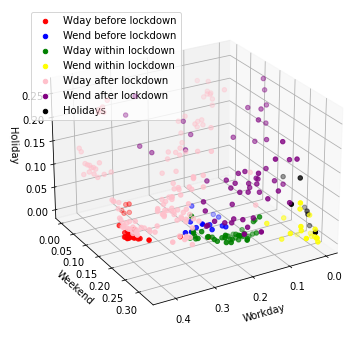

In [29]:
fig, ax = c_all_pop.plot_nmf_3d(return_ax=True)
ax.view_init(elev=25., azim=60)
ax.set_xlabel('Workday')
ax.set_ylabel('Weekend')
ax.set_zlabel('Holiday')


<ipython-input-30-7be6a42fea2b>:7: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


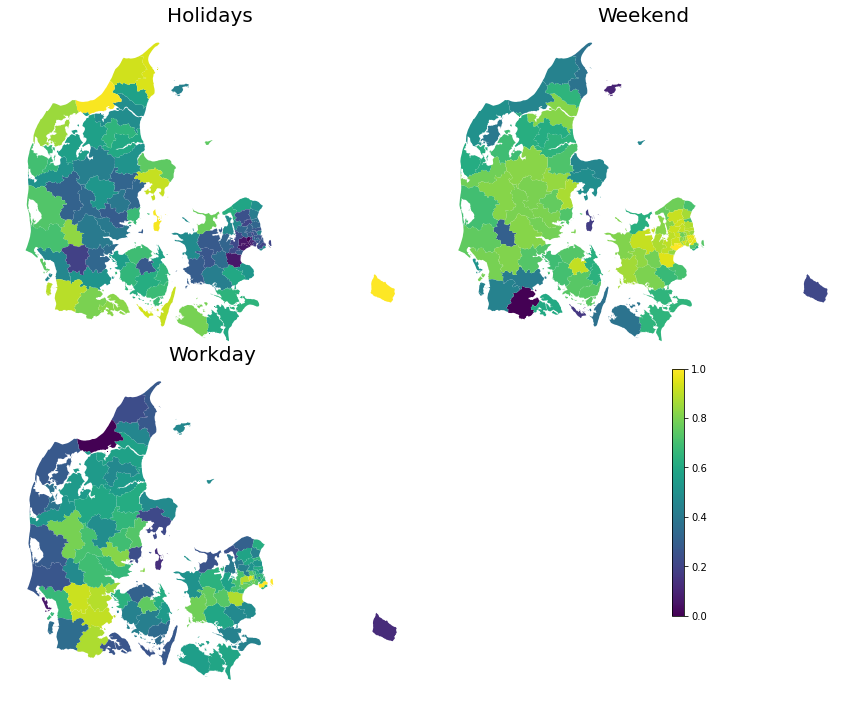

In [30]:
fig, ax = c_all_pop.plot_nmf_geo_map(return_ax=True, column_suffix = '_norm')
norm = colors_.Normalize(vmin=0, vmax=1)
cbar = plt.cm.ScalarMappable(norm=norm)
fig.colorbar(cbar, ax=ax[-1])

# fig.colorbar(cbar, ax=ax.ravel().tolist())
plt.tight_layout()


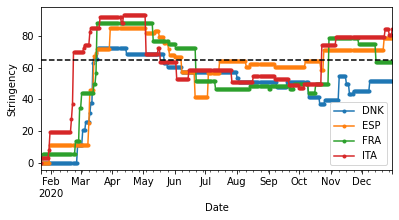

In [31]:
_ = utils.get_lockdown_dates(['DNK','ESP','FRA','ITA'], plot=True)

In [32]:
# Error list
error_list = []

#Save error
N_range = 10 
error_list.append(utils.get_cv_curve(c_all_pop, t_method, subset_n = 40, N_range = N_range))

sns.set()
t_method_str = ['Sqrt, ', 'Identity, ']
data_class_str = ['Outgoing links', 'Ingoing links']
data_pop_str = [', population normalized', '']
fig, ax = plt.subplots(1,1,figsize = (3.2,3))
for ix, i in enumerate(error_list[:1]):
    sns.lineplot(x=np.arange(1,N_range), y=i/i[0], ax=ax)
ax.set_title('Elbow curve')
ax.set_xlabel('k')
ax.set_ylabel('Error')


 11%|█         | 1/9 [00:03<00:28,  3.61s/it]


KeyboardInterrupt: 

# Properties and attributes:

In [33]:
network_type = "_big"
for topic in range(3):
    dat_graph = (data_dict[f'topic_{topic}{network_type}'][data_dict[f'topic_{topic}{network_type}'].total_normalized !=0]).copy()
    dat_graph["inverse"] = (1/dat_graph.total_normalized)
    P = dat_graph.groupby('origin_area_code', as_index = False)['total_normalized'].sum().rename(columns={'total_normalized':'P'})
    dat_graph = pd.merge(dat_graph, P, on='origin_area_code', how='left')
    dat_graph['effective_distance'] = dat_graph.apply(lambda row: (1-np.log(row.total_normalized/row.P)),axis=1)
    G = nx.from_pandas_edgelist(dat_graph, 'origin_area_code', 'destination_area_code', ['inverse', 'effective_distance'], nx.DiGraph)
    print(f"Topic {topic}")
    print(f"Is the graph strongly connected: {nx.is_strongly_connected(G)}")
    print(f"Average clustering coef: {nx.average_clustering(G, weight='inverse')}")
    print(f"Average shortest path: {nx.average_shortest_path_length(G, 'inverse')}")
    print(f"Average shortest path using effective distance: {nx.average_shortest_path_length(G, 'effective_distance')}")
    print(f"Amount of nodes: {len(G.nodes)}")

Topic 0
Is the graph strongly connected: True
Average clustering coef: 0.0018109583507859247
Average shortest path: 5.982064996056366
Average shortest path using effective distance: 6.081236531603423
Amount of nodes: 98
Topic 1
Is the graph strongly connected: True
Average clustering coef: 9.092701793374582e-05
Average shortest path: 8.95138889219347
Average shortest path using effective distance: 6.478595970956441
Amount of nodes: 98
Topic 2
Is the graph strongly connected: True
Average clustering coef: 0.00036996724477935425
Average shortest path: 10.325020761181685
Average shortest path using effective distance: 6.7467153903065
Amount of nodes: 98
